In [2]:
!pip install --upgrade tables
!pip install eli5

     |████████████████████████████████| 4.3MB 2.8MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

In [5]:
cd "/content/drive/My Drive/Colab Notebooks/matrix/matrix_two/dw_matrix_car"

/content/drive/My Drive/Colab Notebooks/matrix/matrix_two/dw_matrix_car


##Wczytywanie danych

In [6]:
df = pd.read_hdf('data/car.h5')
df.shape

(106494, 155)

In [7]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

##Dummy Model

In [8]:
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [13]:
X = df[['car_id']].values
y = df['price_value'].values

model = DummyRegressor()
model.fit(X, y)
y_pred = model.predict(X)

mae(y, y_pred)

39465.934630440985

In [14]:
[x for x in df.columns if 'price' in x]

['price_currency', 'price_details', 'price_value']

In [17]:
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [18]:
df = df[df['price_currency'] != 'EUR']
df.shape

(106290, 155)

##Features

In [23]:
df['param_color'].factorize()[0]

array([-1, -1, -1, ..., -1, -1, -1])

In [0]:
SUFFIX_CAT = '__cat'
for feat in df.columns:
  if isinstance(df[feat][0], list): continue

  factorized_values = df[feat].factorize()[0]
  if SUFFIX_CAT in feat:
    df[feat] = factorized_values
  else :
    df[feat + SUFFIX_CAT] = factorized_values

In [29]:
cat_feats = [x for x in df.columns if SUFFIX_CAT in x ]
cat_feats = [x for x in cat_feats if 'price' not in x]
len(cat_feats)

151

In [30]:
X = df[cat_feats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)

-19566.588937368324

In [43]:
chosen_feats =[ 
               'param_napęd__cat', 
               'param_faktura-vat__cat', 
               'param_stan__cat', 
               'param_rok-produkcji__cat', 
               'param_moc__cat', 
               'feature_kamera-cofania__cat', 
               'param_skrzynia-biegów__cat',
               'param_marka-pojazdu__cat',
               'param_pojemność-skokowa__cat',
               'param_kod-silnika__cat',
               'feature_bluetooth__cat',
               'feature_łopatki_zmiany-biegów__cat',
               'feature_światła-led__cat',
               'feature_klimatyzacja-manualna__cat'
              ]
cat_feats_upg = [x for x in cat_feats if x in chosen_feats]
X2 = df[cat_feats_upg].values
y2 = df['price_value'].values

model_upg = DecisionTreeRegressor(max_depth=5)
scores2 = cross_val_score(model_upg, X2, y2, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores2)

-19531.735231461058

In [32]:
m = DecisionTreeRegressor(max_depth=5)
m.fit(X, y)


imp = PermutationImportance(m, random_state=0).fit(X, y)
eli5.show_weights(imp, feature_names=cat_feats)

Weight,Feature
0.2533 ± 0.0040,param_napęd__cat
0.2008 ± 0.0047,param_faktura-vat__cat
0.1943 ± 0.0088,param_stan__cat
0.1423 ± 0.0086,param_rok-produkcji__cat
0.0629 ± 0.0047,param_moc__cat
0.0424 ± 0.0014,feature_kamera-cofania__cat
0.0412 ± 0.0008,param_skrzynia-biegów__cat
0.0286 ± 0.0037,param_marka-pojazdu__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0163 ± 0.0005,feature_bluetooth__cat


In [0]:
def group_and_barplot(feat_groupby, feat_agg='price_value', agg_funcs=[np.mean, np.median, np.size], feat_sort='mean', top=50, subplots=True):
  return (
    df
    .groupby(feat_groupby)[feat_agg]
    .agg(agg_funcs)
    .sort_values(by=feat_sort, ascending=False)
    .head(top)
  ).plot(kind='bar', figsize=(15, 5), subplots=subplots)

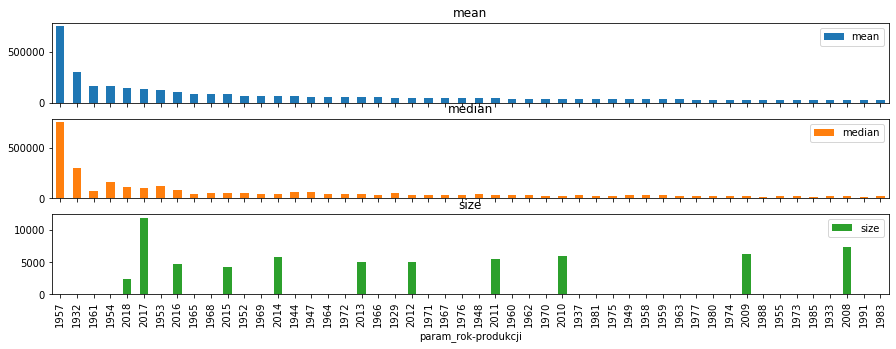

In [35]:
group_and_barplot( 'param_rok-produkcji');

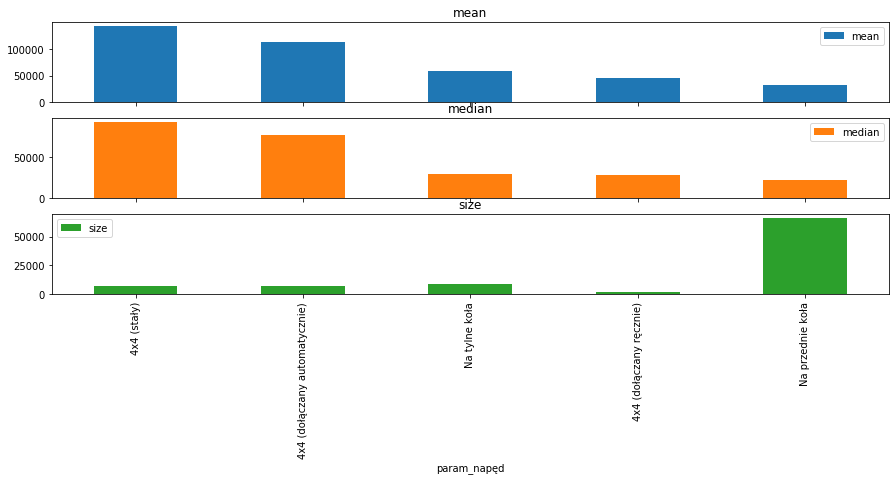

In [34]:
group_and_barplot( 'param_napęd');

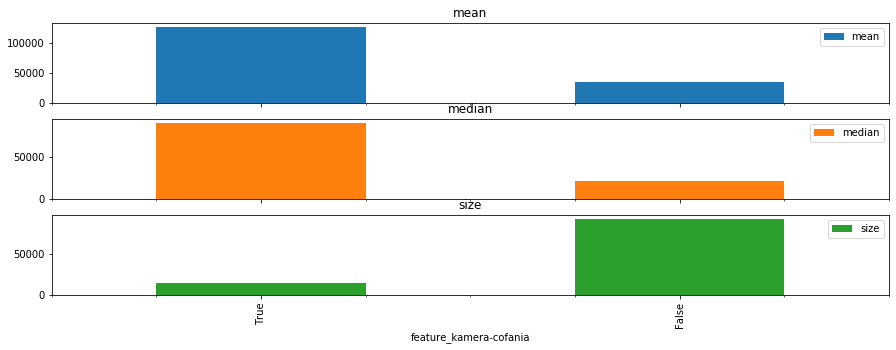

In [36]:
group_and_barplot( 'feature_kamera-cofania');